In [1]:
import uproot
import awkward as ak
import vector
vector.register_awkward()
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import numpy as np

In [2]:
#f = "root://xrootd-cms.infn.it///store/mc/RunIISummer20UL18NanoAODv9/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/164068D4-2101-A34C-BF4A-15AD715B04D4.root"
f = "/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/genfilter/ZHToTauTau_0.root"
#f = "root://eos.grif.fr////eos/grif/cms/llr/store/user/tcuisset/boostedTaus/2018_MC/ZHToTauTau_M125//nano_0.root"
ar_all = uproot.concatenate([f + ":Events"], filter_name=["event", "luminosityBlock", "genWeight", "GenPart*", "LHE*"], library="ak", how="zip")
ar = ar_all[:50000]

In [38]:
genp = ak.with_field(evt.GenPart, ak.local_index(evt.GenPart), "idx")
genp[["idx", "pdgId", "genPartIdxMother"]].show(60)

[{idx: 0, pdgId: 21, genPartIdxMother: -1},
 {idx: 1, pdgId: 21, genPartIdxMother: -1},
 {idx: 2, pdgId: 25, genPartIdxMother: 0},
 {idx: 3, pdgId: 23, genPartIdxMother: 0},
 {idx: 4, pdgId: 5, genPartIdxMother: 0},
 {idx: 5, pdgId: -5, genPartIdxMother: 0},
 {idx: 6, pdgId: 25, genPartIdxMother: 2},
 {idx: 7, pdgId: 23, genPartIdxMother: 3},
 {idx: 8, pdgId: 25, genPartIdxMother: 6},
 {idx: 9, pdgId: 23, genPartIdxMother: 7},
 {idx: 10, pdgId: 25, genPartIdxMother: 8},
 {idx: 11, pdgId: 23, genPartIdxMother: 9},
 {idx: 12, pdgId: 25, genPartIdxMother: 10},
 {idx: 13, pdgId: 23, genPartIdxMother: 11},
 {idx: 14, pdgId: 25, genPartIdxMother: 12},
 {idx: 15, pdgId: 23, genPartIdxMother: 13},
 {idx: 16, pdgId: 25, genPartIdxMother: 14},
 {idx: 17, pdgId: 23, genPartIdxMother: 15},
 {idx: 18, pdgId: -15, genPartIdxMother: 17},
 {idx: 19, pdgId: 15, genPartIdxMother: 17},
 {idx: 20, pdgId: 15, genPartIdxMother: 16},
 {idx: 21, pdgId: -15, genPartIdxMother: 16},
 {idx: 22, pdgId: -5, genPart

(-26.8178466796875, 400.0)

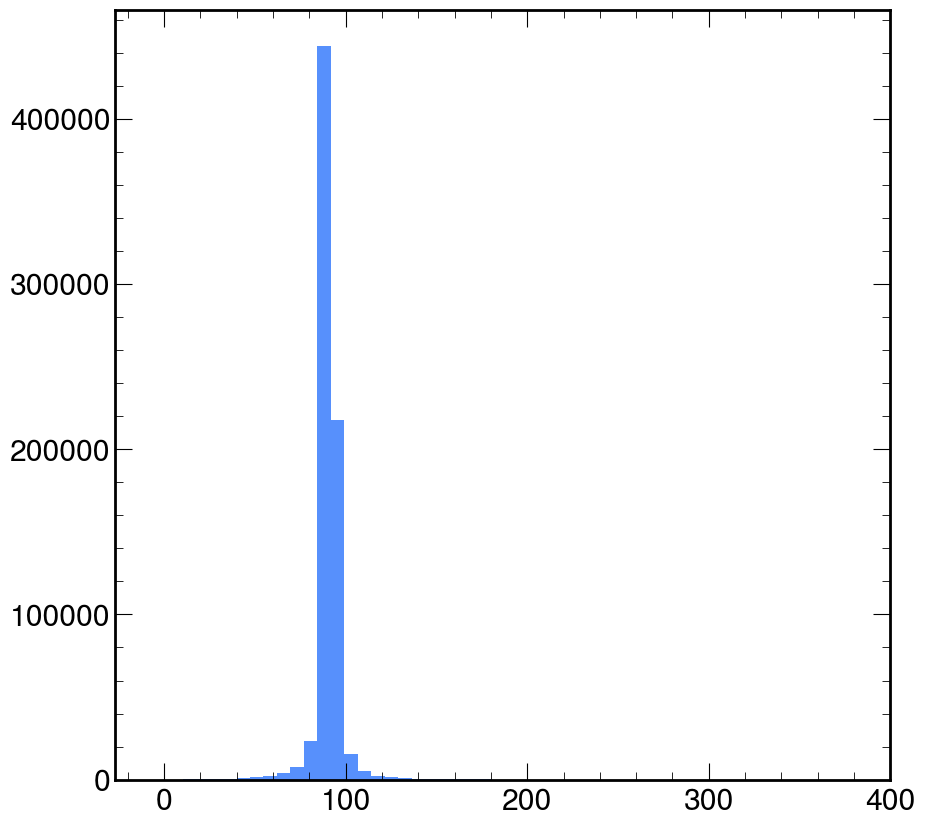

In [24]:
plt.hist(ak.flatten(ar_all.LHEPart[ar_all.LHEPart.status==2].mass), bins=100)
#plt.yscale("log")
plt.xlim(right=400)

In [27]:
ar.LHEPart[(ar.LHEPart.status>0) & (ar.LHEPart.pdgId==25)][["mass", "pt"]]

<Array [[{mass: 125, pt: 34.7}], ..., [{...}]] type='50000 * var * {mass: f...'>

In [22]:
printParents(evt.GenPart, evt.GenPart[evt.GenPart.pdgId == 25][-1])

PDG=25
PDG=25
PDG=25
PDG=25
PDG=25
PDG=25
PDG=25
PDG=21


In [3]:
def genPairType_branch(ar):
    """ select etau, mutau, tautau at genlevel"""
    tautau = ak.num(ar.GenVisTau) == 2

    mutau_genMuon_bool = (abs(ar.GenPart.pdgId) == 13) & (abs(ar.GenPart[ar.GenPart.genPartIdxMother].pdgId) == 15)
    mutau_genMuon_idx = ak.firsts(ak.local_index(ar.GenPart)[mutau_genMuon_bool]) # index of gen muon in GenPart collection
    mutau = (ak.num(ar.GenVisTau) == 1) & ak.any(mutau_genMuon_bool, axis=-1)
    
    etau_genMuon_bool = (abs(ar.GenPart.pdgId) == 11) & (abs(ar.GenPart[ar.GenPart.genPartIdxMother].pdgId) == 15)
    etau_genMuon_idx = ak.firsts(ak.local_index(ar.GenPart)[etau_genMuon_bool]) # index of gen muon in GenPart collection
    etau = (ak.num(ar.GenVisTau) == 1) & ak.any(etau_genMuon_bool, axis=-1)
    
    genPairType =  ak.where(mutau, 0, ak.where(etau, 1, ak.where(tautau, 2, -1)))
    genLeptonIdx = ak.where(mutau, mutau_genMuon_idx, etau_genMuon_idx) # for tautau will just put None
    return ak.with_field(ak.with_field(ar, genPairType, where="genPairType"), genLeptonIdx, "genLeptonIdx")
statusFlags_doc = {0 : "isPrompt", 1 : "isDecayedLeptonHadron", 2 : "isTauDecayProduct", 3 : "isPromptTauDecayProduct", 4 : "isDirectTauDecayProduct", 5 : "isDirectPromptTauDecayProduct", 6 : "isDirectHadronDecayProduct", 7 : "isHardProcess", 8 : "fromHardProcess", 9 : "isHardProcessTauDecayProduct", 10 : "isDirectHardProcessTauDecayProduct", 11 : "fromHardProcessBeforeFSR", 12 : "isFirstCopy", 13 : "isLastCopy", 14 : "isLastCopyBeforeFSR"}
def readStatusFlagsBits(val):
    s = ""
    for bitn in statusFlags_doc.keys():
        is_bit_set = (val & (1 << bitn)) != 0
        if is_bit_set:
            s += statusFlags_doc[bitn] + ", "
    return s

In [4]:
# 5=b, 23=Z
def select_bb(ar):
    gen_b = (abs(ar.GenPart.pdgId) == 5) & (ar.GenPart[ar.GenPart.genPartIdxMother].pdgId == 23) 
    return ak.count_nonzero(gen_b, axis=-1) >=2
def select_tautau_genpart(ar):
    gen_tau = (abs(ar.GenPart.pdgId) == 15) & (ar.GenPart[ar.GenPart.genPartIdxMother].pdgId == 23) 
    return ak.count_nonzero(gen_tau, axis=-1) >=2
def select_bb_lhe(ar):
    return ak.num(ar.LHEPart[(ar.LHEPart.pdgId == 5)&(ar.LHEPart.status==1)], axis=-1) + ak.num(ar.LHEPart[(ar.LHEPart.pdgId == -5)&(ar.LHEPart.status==1)], axis=-1) >= 2
def select_tautau_lhe(ar):
    return ak.num(ar.LHEPart[ar.LHEPart.pdgId == 15], axis=-1) + ak.num(ar.LHEPart[ar.LHEPart.pdgId == -15], axis=-1) >= 2
def select_tautau_genpart_fromOther(ar, mother_pdg):
    gen_tau = (abs(ar.GenPart.pdgId) == 15) & (ar.GenPart[ar.GenPart.genPartIdxMother].pdgId == mother_pdg) 
    return ak.count_nonzero(gen_tau, axis=-1) >=2
def printParents(genparts, genpart):
    print(f"PDG={genpart.pdgId}")
    if genpart.genPartIdxMother >= 0:
        printParents(genparts, genparts[genpart.genPartIdxMother])


In [30]:
ar_s.GenPart[abs(ar_s.GenPart.pdgId) == 15][2][["eta", "pt", "statusFlags", "genPartIdxMother"]]

<Array [{eta: 2.59, pt: 11.9, ...}, ..., {...}] type='4 * {eta: float32, pt...'>

In [48]:
ar_s.LHEPart[abs(ar_s.LHEPart.pdgId) == 15][2]

<Array [{pt: 11.1, eta: 2.6, ...}, {...}] type='2 * {pt: float32, eta: floa...'>

In [36]:
ar_s.GenPart[ar_s.GenPart.genPartIdxMother == 3][2][["eta", "pt", "pdgId", "statusFlags", "genPartIdxMother"]]

<Array [{eta: 2.55, pt: 12.6, pdgId: -15, ...}] type='1 * {eta: float32, pt...'>

In [40]:
ar_s.GenPart[2][0]

<Record {eta: 2.37e+04, mass: 0, phi: 0, ...} type='{eta: float32, mass: fl...'>

In [39]:
print(readStatusFlagsBits(8451))
print(readStatusFlagsBits(4481))
None

isPrompt, isDecayedLeptonHadron, fromHardProcess, isLastCopy, 
isPrompt, isHardProcess, fromHardProcess, isFirstCopy, 


In [5]:
gen_b = (abs(ar.GenPart.pdgId) == 5) & (ar.GenPart[ar.GenPart.genPartIdxMother].pdgId == 23) 
ak.count_nonzero(gen_b, axis=-1)

<Array [2, 0, 0, 0, 2, 0, 2, 0, ..., 0, 0, 0, 0, 2, 0, 0] type='10000 * int64'>

In [19]:
v_b = vector.Array(ar.GenPart[gen_b][["pt", "eta", "phi", "mass"]])[ak.count_nonzero(gen_b, axis=-1) == 2]
v_b

<MomentumArray4D [[{rho: 35.4, phi: ..., ...}, ...], ...] type='2158 * var ...'>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe52ddffc50>, errorbar=None, legend_artist=None)]

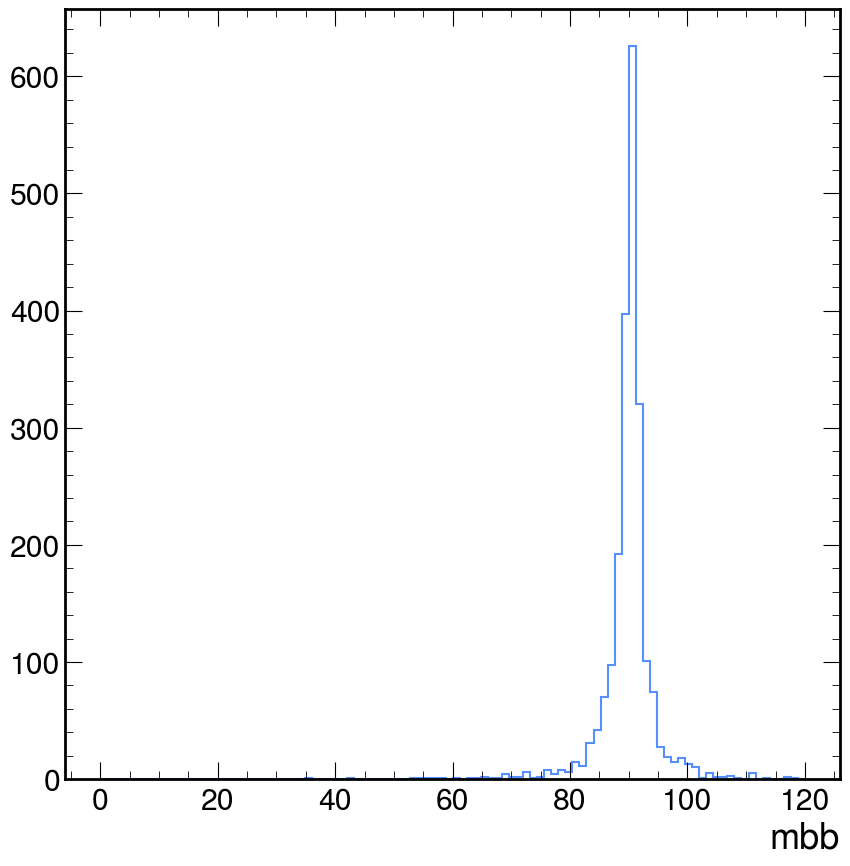

In [28]:
h = hist.Hist(hist.axis.Regular(100, 0., 120., name="mbb")).fill((v_b[:, 0] + v_b[:, 1]).M)
hep.histplot(h, yerr=False)

In [57]:
ar.GenPart[gen_tau & ((ar.GenPart.statusFlags & (1 << 0))!=0)]

<Array [[{eta: 4.55, ...}, ..., {...}], ...] type='10000 * var * {eta: floa...'>

<BarContainer object of 22 artists>

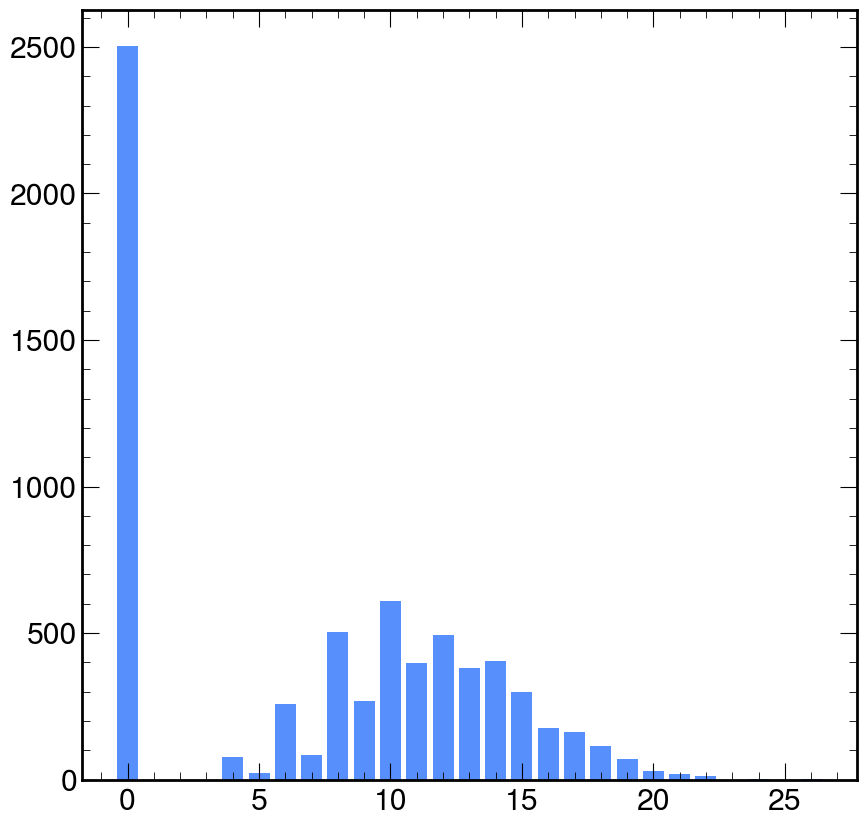

In [64]:
gen_tau = (abs(ar.GenPart.pdgId) == 15) # tau=15
mothers = ak.flatten(ar.GenPart[gen_tau & ((ar.GenPart.statusFlags & (1 << 0))!=0) & ((ar.GenPart.statusFlags & (1 << 7))!=0)].genPartIdxMother) # 0=isPrompt, 7 isHardProcess
plt.bar(*np.unique(mothers, return_counts=True))

In [59]:
(ar.GenPart.statusFlags & (1 << 0))

<Array [[1, 1, 1, 1, 1, 1, ..., 0, 0, 0, 0, 0], ...] type='10000 * var * int32'>

In [65]:
for st in ak.flatten(ar.GenPart[gen_tau].statusFlags):
    if (st & (1<<0)) != 0 and (st & (1<<7)) != 0:
        print(readStatusFlagsBits(st))

isPrompt, isHardProcess, fromHardProcess, isFirstCopy, 
isPrompt, isHardProcess, fromHardProcess, isFirstCopy, 
isPrompt, isHardProcess, fromHardProcess, isFirstCopy, 
isPrompt, isHardProcess, fromHardProcess, isFirstCopy, 
isPrompt, isDecayedLeptonHadron, isHardProcess, fromHardProcess, isFirstCopy, isLastCopy, 
isPrompt, isDecayedLeptonHadron, isHardProcess, fromHardProcess, isFirstCopy, isLastCopy, 
isPrompt, isDecayedLeptonHadron, isHardProcess, fromHardProcess, isFirstCopy, isLastCopy, 
isPrompt, isDecayedLeptonHadron, isHardProcess, fromHardProcess, isFirstCopy, isLastCopy, 
isPrompt, isDecayedLeptonHadron, isHardProcess, fromHardProcess, isFirstCopy, isLastCopy, 
isPrompt, isDecayedLeptonHadron, isHardProcess, fromHardProcess, isFirstCopy, isLastCopy, 
isPrompt, isHardProcess, fromHardProcess, isFirstCopy, 
isPrompt, isHardProcess, fromHardProcess, isFirstCopy, 
isPrompt, isHardProcess, fromHardProcess, isFirstCopy, 
isPrompt, isHardProcess, fromHardProcess, fromHardProcessBefor

In [44]:
ak.count_nonzero(gen_tau, axis=-1)

<Array [6, 0, 4, 0, 0, 0, 0, 2, ..., 0, 0, 2, 0, 0, 0, 0] type='10000 * int64'>

In [46]:
ar.GenPart[gen_tau][7][0]

<Record {eta: 3.61, mass: 0, phi: -2.23, ...} type='{eta: float32, mass: fl...'>

In [47]:
f"{12675:b}"

'11000110000011'

<Array [[{pt: 7.52, eta: 4.28, ...}], ..., []] type='50000 * var * {pt: flo...'>

## Plotting mtautau

In [7]:
ar_plot = ar_all[select_tautau_lhe(ar_all)]

In [8]:
higgs = select_tautau_genpart_fromOther(ar_plot, 25)
z = select_tautau_genpart_fromOther(ar_plot, 23)
gamma = select_tautau_genpart_fromOther(ar_plot, 22)
ak.count_nonzero(gamma)

1

In [23]:
def m_tautau(ar):
    v_tau = vector.Array(ar.LHEPart[abs(ar.LHEPart.pdgId) == 15][["pt", "eta", "phi", "mass"]])
    return (v_tau[:, 0] + v_tau[:, 1]).M
def m_tautau_hist(ar):
    return hist.Hist(hist.axis.Regular(100, 0., 140., name="mtautau"), storage="weight").fill(m_tautau(ar), weight=ar.genWeight)

In [21]:
m_tautau_hist(ar_plot[(~z)&(~higgs)]).values()

array([0.00000000e+00, 0.00000000e+00, 3.39418791e-02, 2.13037960e-01,
       1.51474413e-01, 1.06897412e-01, 7.61234419e-02, 5.95660471e-02,
       4.61375473e-02, 3.76637817e-02, 2.98766563e-02, 2.40636218e-02,
       2.14497070e-02, 1.69553341e-02, 1.48563995e-02, 1.28432949e-02,
       1.16026607e-02, 1.00733255e-02, 8.43475202e-03, 7.56084616e-03,
       6.53088570e-03, 6.17976281e-03, 5.67258531e-03, 5.07957776e-03,
       4.78307399e-03, 4.08863095e-03, 3.82333810e-03, 3.42539883e-03,
       3.12889506e-03, 3.00405137e-03, 2.38763563e-03, 2.13794824e-03,
       2.33301652e-03, 2.28620013e-03, 2.07552640e-03, 2.15355371e-03,
       1.83364174e-03, 2.06772367e-03, 1.80243082e-03, 1.52933524e-03,
       1.24843693e-03, 1.11579051e-03, 1.21722601e-03, 1.07677685e-03,
       7.80273082e-04, 1.03776320e-03, 9.20722237e-04, 8.03681274e-04,
       9.51933160e-04, 6.94443043e-04, 7.64667620e-04, 6.16415735e-04,
       7.25653966e-04, 5.14980234e-04, 6.47626658e-04, 5.07177503e-04,
      

Text(0, 1, 'Generator weights')

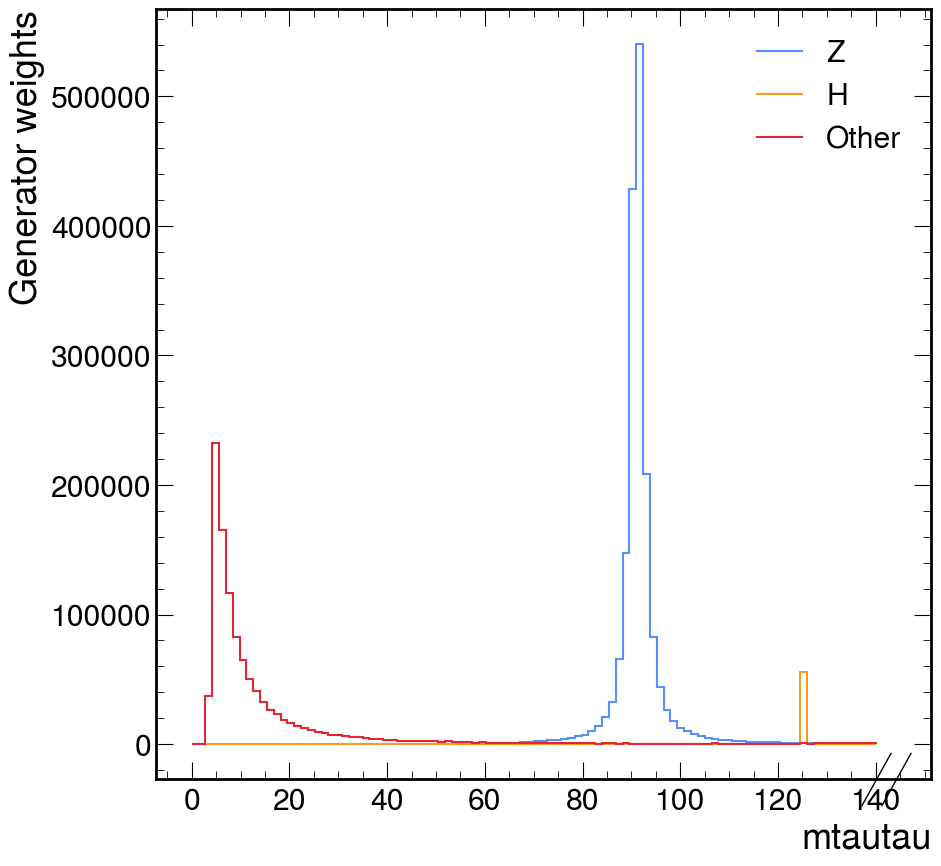

In [25]:
hep.histplot([m_tautau_hist(ar_plot[z]), m_tautau_hist(ar_plot[higgs]), m_tautau_hist(ar_plot[(~z)&(~higgs)])], yerr=False, label=["Z", "H", "Other"])
plt.legend()
plt.ylabel("Generator weights")

In [29]:
ak.sum(ar_plot[(~z)&(~higgs)].genWeight) / ( ak.sum(ar_plot[z].genWeight) + ak.sum(ar_plot[(~z)&(~higgs)].genWeight))

0.38364407

In [31]:
ak.sum(ar_plot[(~z)&(~higgs)].genWeight) / ( ak.sum(ar_plot[z].genWeight))

0.62243915

In [30]:
len(ar_plot[(~z)&(~higgs)].genWeight) / ( len(ar_plot[z].genWeight) + len(ar_plot[(~z)&(~higgs)].genWeight))

0.3716038885198019